# Introduction - Lecture 1


**Goals of This Lecture:**

- **Section 1:** Generate and visualize three types of time series:
  1. Brownian motion (stochastic process)
  2. Lorenz attractor (chaotic system)
  3. Lotka-Volterra system (deterministic system of differential equations)

  You will get an initial taste of what time series are, and how they might look very different depending on their underlying processes.

- **Section 2:** Work with missing values on one chosen time series (Brownian motion).
  You will learn how to:
  - Fill missing values with the previous available value (forward fill).
  - Fill missing values by averaging neighboring values.
  - Perform interpolation to fill missing values smoothly.

  You will see the pros and cons of each approach and visualize them clearly.

- **Section 3:** Preprocessing and scaling a chosen time series.
  You will learn how to:
  - Apply differencing
  - Apply log-differencing
  - Normalize and standardize your data
  - Reverse these transformations to recover the original form

  You will also discuss when and why these transformations might be helpful.

- **Section 4:** Perform seasonal decomposition and basic Exploratory Data Analysis (EDA).
  You will learn about:
  - Seasonal decomposition to identify trend, seasonal, and residual components.
  - Basic EDA techniques for time series to understand its underlying patterns and what matters for forecasting.

Throughout the notebook, you are encouraged to think about the reasoning behind each step. You will see comments and explanations written as if talking directly to you as a student.


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm

sns.set()
plt.style.use('ggplot')


## SECTION 1: Generating and Visualizing Different Types of Time Series

You will now see three different types of time series:

1. **Brownian Motion (Random Walk)**:
   This is a stochastic process where each step is a random jump from the previous value.
   - *Intuition:* Imagine a drunk person stumbling around, their next position is their old position plus some random movement.

2. **Lorenz Attractor (Chaotic System)**:
   The Lorenz equations are a system of ordinary differential equations that demonstrate chaos. Although deterministic, small changes in initial conditions lead to vastly different outcomes.
   - *Intuition:* It's like a complex weather system—predictable in short term, but sensitive to small changes and quickly becoming hard to predict.

3. **Lotka-Volterra Equations (Predator-Prey System)**:
   These equations model the interaction of two species: a prey population and a predator population.
   - *Intuition:* When there are more prey, predators thrive, when predators become too many, prey diminish, etc. The populations oscillate in a deterministic manner.


In [2]:
# -----------------------------------------
# Section 1: Generate Brownian Motion (Random Walk)
# -----------------------------------------
# You may recognize Brownian motion as a simple stochastic process.
# Here, you start from zero and add random steps. The cumulative sum
# of these random steps forms a random walk.
np.random.seed(42)  # Ensuring reproducibility
n = 300
steps = np.random.normal(loc=0, scale=1, size=n)  # Random steps from a normal distribution
brownian = np.cumsum(steps)  # Brownian motion as a cumulative sum of random steps

# -----------------------------------------
# Section 2: Generate Lorenz Attractor Time Series
# -----------------------------------------
# The Lorenz system is a set of deterministic ODEs that produce chaotic solutions.
# Even though it's deterministic, the system is highly sensitive to initial conditions.
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

def lorenz(X, t):
    x, y, z = X
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

t = np.linspace(0, 50, n)
X0 = [1.0, 1.0, 1.0]  # Initial condition
X = odeint(lorenz, X0, t)
lorenz_ts = X[:, 0]  # Extracting the x-component of the Lorenz system as a time series

# -----------------------------------------
# Section 3: Generate Lotka-Volterra (Predator-Prey) Time Series
# -----------------------------------------
# The Lotka-Volterra equations model the interaction between prey and predator populations.
# With certain parameters, you get cyclical oscillations in population levels.
alpha = 0.5    # Prey birth rate
beta_ = 0.02   # Rate at which predators consume prey
gamma = 0.4    # Predator death rate
delta = 0.01   # Predator growth rate based on consumed prey

def lotka_volterra(Y, t):
    prey, pred = Y
    dprey_dt = alpha * prey - beta_ * prey * pred
    dpred_dt = delta * prey * pred - gamma * pred
    return [dprey_dt, dpred_dt]

Y0 = [40, 9]  # Initial populations: Prey=40, Predator=9
t_lv = np.linspace(0, 200, 1000)  # More time points to see multiple cycles
Y = odeint(lotka_volterra, Y0, t_lv)
prey_ts = Y[:, 0]
pred_ts = Y[:, 1]

### Visualizing the Generated Time Series

You should now visualize these three series and observe their differences. Notice how one is entirely random, another shows chaotic fluctuations, and the last shows more regular oscillations (though still complex).


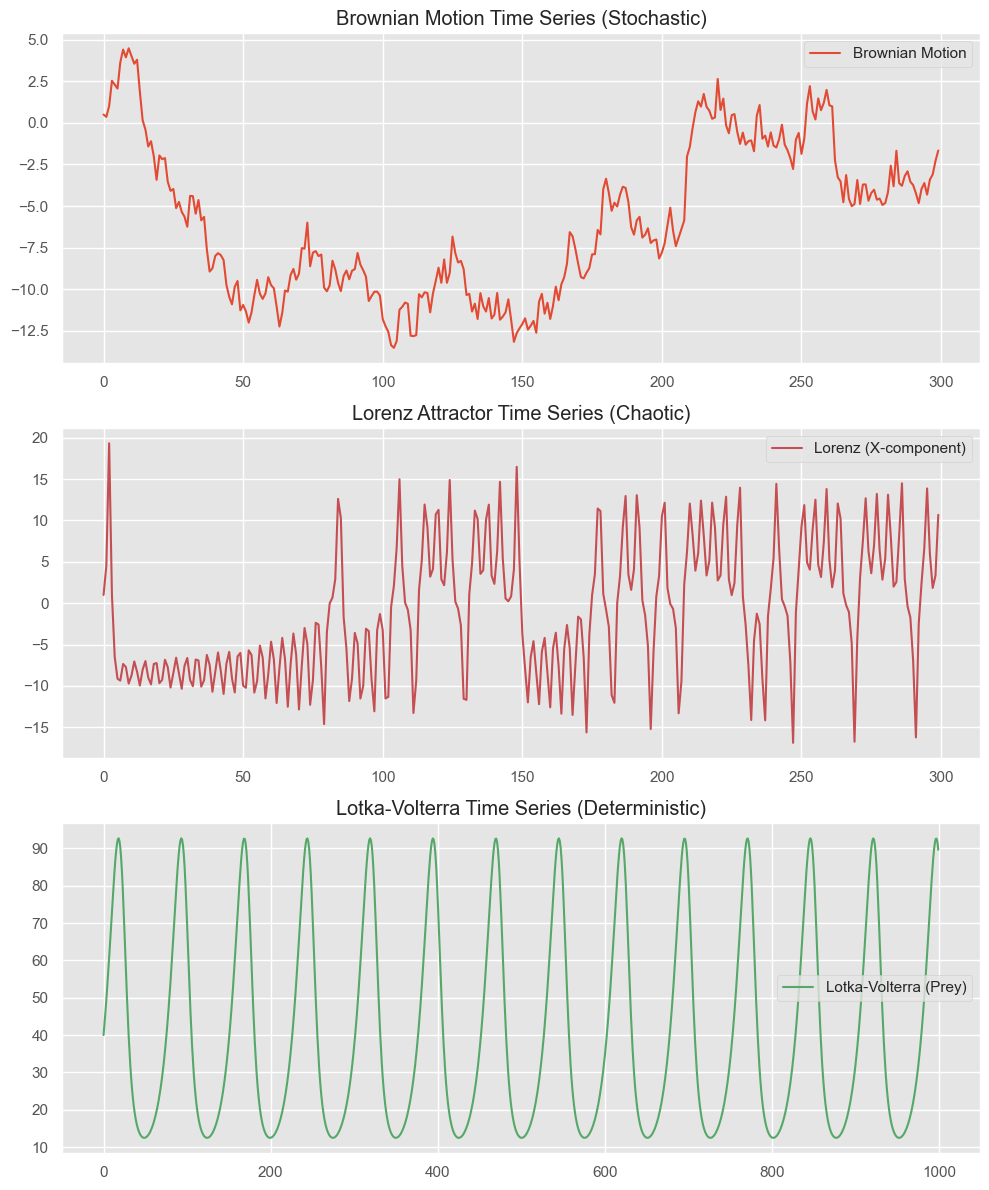

In [3]:
# -----------------------------------------
# Visualization
# -----------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Brownian Motion Plot
axs[0].plot(brownian, label='Brownian Motion')
axs[0].set_title("Brownian Motion Time Series (Stochastic)")
axs[0].legend()

# Lorenz Attractor Plot
axs[1].plot(lorenz_ts, color='r', label='Lorenz (X-component)')
axs[1].set_title("Lorenz Attractor Time Series (Chaotic)")
axs[1].legend()

# Lotka-Volterra Plot
axs[2].plot(prey_ts, color='g', label='Lotka-Volterra (Prey)')
axs[2].set_title("Lotka-Volterra Time Series (Deterministic)")
axs[2].legend()

plt.tight_layout()
plt.show()

**Discussion:**

- The Brownian motion looks like a "drifting" series with no clear pattern. You might find it quite unpredictable.
- The Lorenz series looks more complicated and "irregular", but remember it's still deterministic—just very sensitive to initial conditions.
- The Lotka-Volterra time series shows oscillations, increasing and decreasing in a somewhat regular pattern.

You need to keep in mind that time series can originate from different phenomena and exhibit a wide range of behaviors.

---

## SECTION 2: Handling Missing Values

In real-world data, you will often encounter missing values. You need to know how to deal with them. Here, you'll take the Brownian motion series and introduce some missing values, then try different methods to fill them.

You may find that:
- Forward filling (using the last available value) is simple but may create plateaus.
- Averaging neighbors might smooth transitions.
- Interpolation can provide a more natural guess at missing points.


In [4]:
# -----------------------------------------------
# STEP 1: CREATE THE ORIGINAL BROWNIAN MOTION DATA
# -----------------------------------------------
# You create a simple Brownian motion (random walk) by cumulatively summing random steps.
np.random.seed(42)
n = 300
steps = np.random.normal(loc=0, scale=1, size=n)
brownian = np.cumsum(steps)

# ------------------------------------------------
# STEP 2: INTRODUCE MULTIPLE MISSING VALUE REGIONS
# ------------------------------------------------
# Here, you introduce several disjoint intervals of missing values.
# This simulates real-world scenarios where data might be missing in multiple places.
brownian_with_nans = brownian.copy()
missing_regions = [(50, 55), (100, 102), (200, 205)]
for start, end in missing_regions:
    brownian_with_nans[start:end] = np.nan

**Now, you will fill the missing values using different strategies:**

1. **Forward Fill:** Replace missing values with the most recent non-missing value.
2. **Average of Neighbors:** Replace a missing value with the average of its immediate neighbors.
3. **Interpolation:** Use linear interpolation between known points to estimate the missing values.


In [5]:
# ---------------------------------------------------
# STEP 3: DEFINE THE FILLING METHODS
# ---------------------------------------------------
# (1) Forward Fill:
# Forward fill replaces each NaN with the last known value before it.
brownian_ffill = pd.Series(brownian_with_nans).ffill().values

# (2) Average of Neighbors:
# For each missing value, you will replace it with the average of its immediate neighbors.
# You need to handle ALL missing intervals, not just the first one.
brownian_avg = brownian_with_nans.copy()
for start, end in missing_regions:
    for i in range(start, end):
        if i > 0 and i < len(brownian_avg)-1:
            # Take average of the value before and after the missing point
            left_val = brownian_avg[i-1]
            right_val = brownian_avg[i+1]
            # Only fill if both neighbors are not NaN, otherwise, skip or handle differently
            if not np.isnan(left_val) and not np.isnan(right_val):
                brownian_avg[i] = 0.5*(left_val + right_val)
            else:
                # If a neighbor is also missing, you could choose another strategy,
                # such as forward fill or skip. For simplicity, let's forward fill here.
                brownian_avg[i] = brownian_avg[i-1]

# (3) Linear Interpolation:
# Interpolation will fill the missing values by forming a straight line between the known points before and after the gap.
brownian_interp = pd.Series(brownian_with_nans).interpolate(method='linear').values


### Visualizing the Different Filling Techniques

You need to compare these results side-by-side to understand their differences.

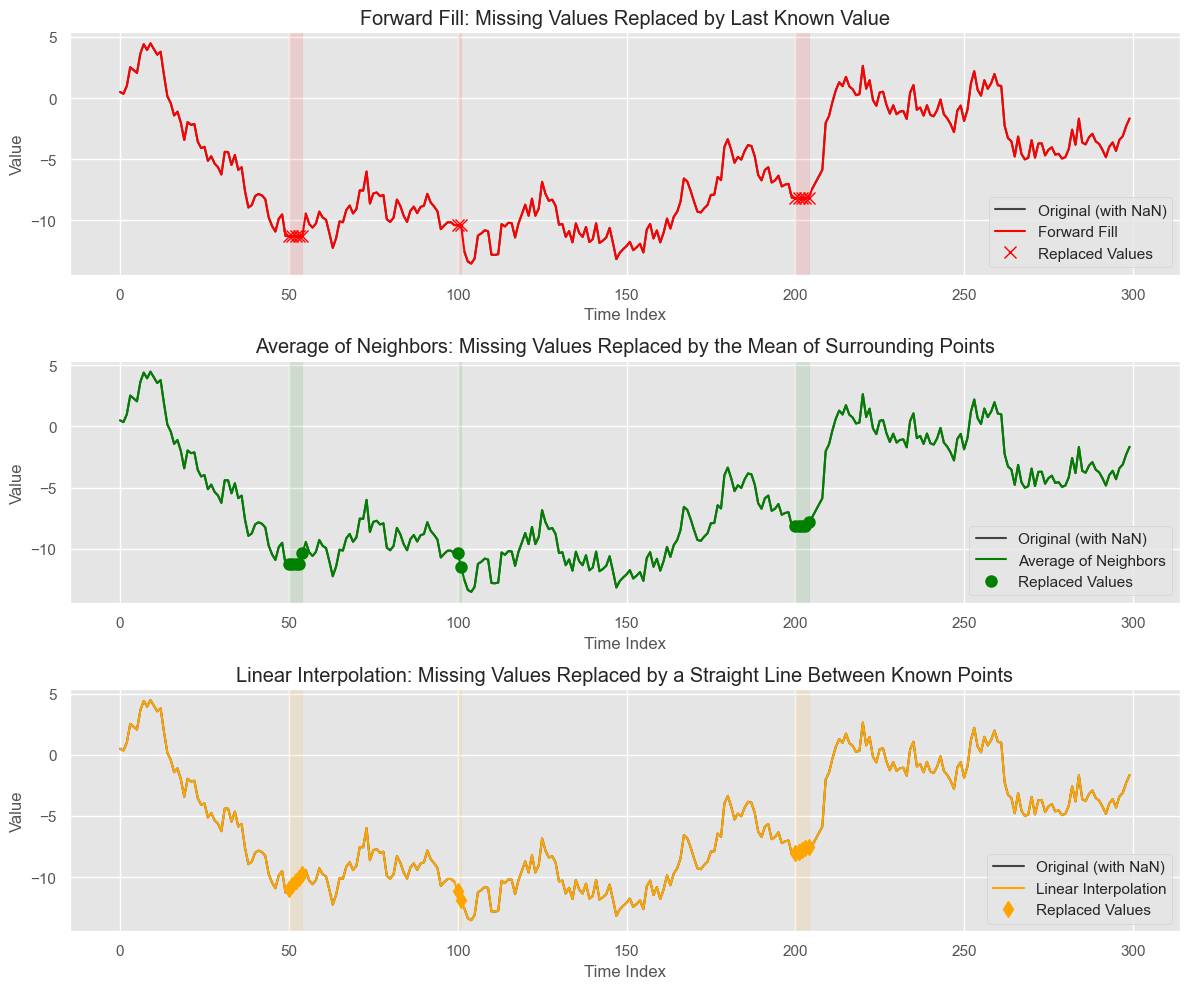

In [6]:
# ---------------------------------------------------
# STEP 4: VISUALIZATION
# ---------------------------------------------------
# You will create a subplot for each method to compare the original data (with NaNs) and the filled data.
# In each subplot:
# - The original data (with NaNs) is shown as a black line with gaps.
# - The filled data is shown in a distinct color line.
# - The missing regions are highlighted with a shaded area.
# - The replaced (filled-in) values are marked with a distinct marker in the same color as the line to draw attention.

fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# To make it easier to highlight all missing regions consistently, let's do a small helper function:
def highlight_missing_regions(ax, regions, color):
    for (start, end) in regions:
        # Highlight the missing region with a transparent shaded rectangle
        ax.axvspan(start, end-1, color=color, alpha=0.1)

def mark_filled_points(ax, original_with_nans, filled_data, regions, marker_color, marker_style):
    # Mark each originally missing value now filled
    for (start, end) in regions:
        missing_x = np.arange(start, end)
        # The filled values at these indices
        missing_y = filled_data[start:end]
        ax.plot(missing_x, missing_y, marker_style, color=marker_color, markersize=8,
                label='Replaced Values' if start == regions[0][0] else None)


# -----------------------
# Subplot 1: Forward Fill
# -----------------------
axs[0].plot(brownian_with_nans, label='Original (with NaN)', color='black', alpha=0.7)
axs[0].plot(brownian_ffill, label='Forward Fill', color='red')
highlight_missing_regions(axs[0], missing_regions, 'red')
mark_filled_points(axs[0], brownian_with_nans, brownian_ffill, missing_regions, 'red', 'x')

axs[0].set_title("Forward Fill: Missing Values Replaced by Last Known Value")
axs[0].set_xlabel("Time Index")
axs[0].set_ylabel("Value")
axs[0].legend()

# ----------------------------
# Subplot 2: Average of Neighbors
# ----------------------------
# Plot original
axs[1].plot(brownian_with_nans, color='black', alpha=0.7, label='Original (with NaN)')
# Plot filled result
axs[1].plot(brownian_avg, color='green', label='Average of Neighbors')
highlight_missing_regions(axs[1], missing_regions, 'green')
mark_filled_points(axs[1], brownian_with_nans, brownian_avg, missing_regions, 'green', 'o')

axs[1].set_title("Average of Neighbors: Missing Values Replaced by the Mean of Surrounding Points")
axs[1].set_xlabel("Time Index")
axs[1].set_ylabel("Value")
axs[1].legend()

# ----------------------------
# Subplot 3: Linear Interpolation
# ----------------------------
axs[2].plot(brownian_with_nans, color='black', alpha=0.7, label='Original (with NaN)')
axs[2].plot(brownian_interp, color='orange', label='Linear Interpolation')
highlight_missing_regions(axs[2], missing_regions, 'orange')
mark_filled_points(axs[2], brownian_with_nans, brownian_interp, missing_regions, 'orange', 'd')

axs[2].set_title("Linear Interpolation: Missing Values Replaced by a Straight Line Between Known Points")
axs[2].set_xlabel("Time Index")
axs[2].set_ylabel("Value")
axs[2].legend()

plt.tight_layout()
plt.show()

**Discussion:**
- **Forward Fill:**
  You may find it simple and quick. But if a long gap occurs, the filled segment becomes a flat line, which may not be realistic.

- **Average of Neighbors:**
  This might be slightly better than a flat line, but it still does not take into account the overall trend. It just bridges the gap linearly between immediate neighbors.

- **Interpolation:**
  Interpolation tries to create a smooth transition. You may find it more "natural" for certain time series, but if the data is highly non-linear or seasonal, simple linear interpolation might still be an oversimplification.

The choice depends on the nature of your data and the analysis you wish to do.

---

## SECTION 3: Preprocessing, Scaling, and Reversing Transformations

In this section, you will choose one time series again (let's pick the Lorenz attractor series for variety) and demonstrate various preprocessing steps.

You need to understand these common transformations:
- **Differencing:** Remove trends by looking at changes rather than absolute values.
- **Log-Differencing:** Stabilize variance and remove trends, often used when dealing with multiplicative trends.
- **Normalization (Min-Max):** Scale data to [0,1].
- **Standardization (Z-score):** Transform data to have mean 0 and std 1.

You will also learn how to invert these transformations, because after modeling or forecasting, you often need to revert the predictions back to the original scale.


In [7]:
# Use the Lorenz attractor time series
lorenz_series = lorenz_ts.copy()

# 1. Differencing
lorenz_diff = np.diff(lorenz_series)

# To invert differencing, you need the initial value
lorenz_recovered_from_diff = np.insert(np.cumsum(lorenz_diff) + lorenz_series[0], 0, lorenz_series[0])

# 2. Log-Differencing (make sure all values are positive)
# Lorenz might have negative values, let's shift it to make all positive:
shift_value = np.abs(np.min(lorenz_series)) + 1
lorenz_shifted = lorenz_series + shift_value
lorenz_log = np.log(lorenz_shifted)
lorenz_log_diff = np.diff(lorenz_log)

# To invert log-differencing:
lorenz_log_recovered = np.exp(np.insert(np.cumsum(lorenz_log_diff) + lorenz_log[0], 0, lorenz_log[0]))
lorenz_log_recovered_final = lorenz_log_recovered - shift_value

# 3. Normalization (Min-Max)
min_val = np.min(lorenz_series)
max_val = np.max(lorenz_series)
lorenz_norm = (lorenz_series - min_val) / (max_val - min_val)
# Invert normalization:
lorenz_norm_inv = lorenz_norm * (max_val - min_val) + min_val

# 4. Standardization (Z-score)
mean_val = np.mean(lorenz_series)
std_val = np.std(lorenz_series)
lorenz_std = (lorenz_series - mean_val) / std_val
# Invert standardization:
lorenz_std_inv = lorenz_std*std_val + mean_val


### Visualizations and Discussions

You should now visualize and discuss each transformation and its inversion.


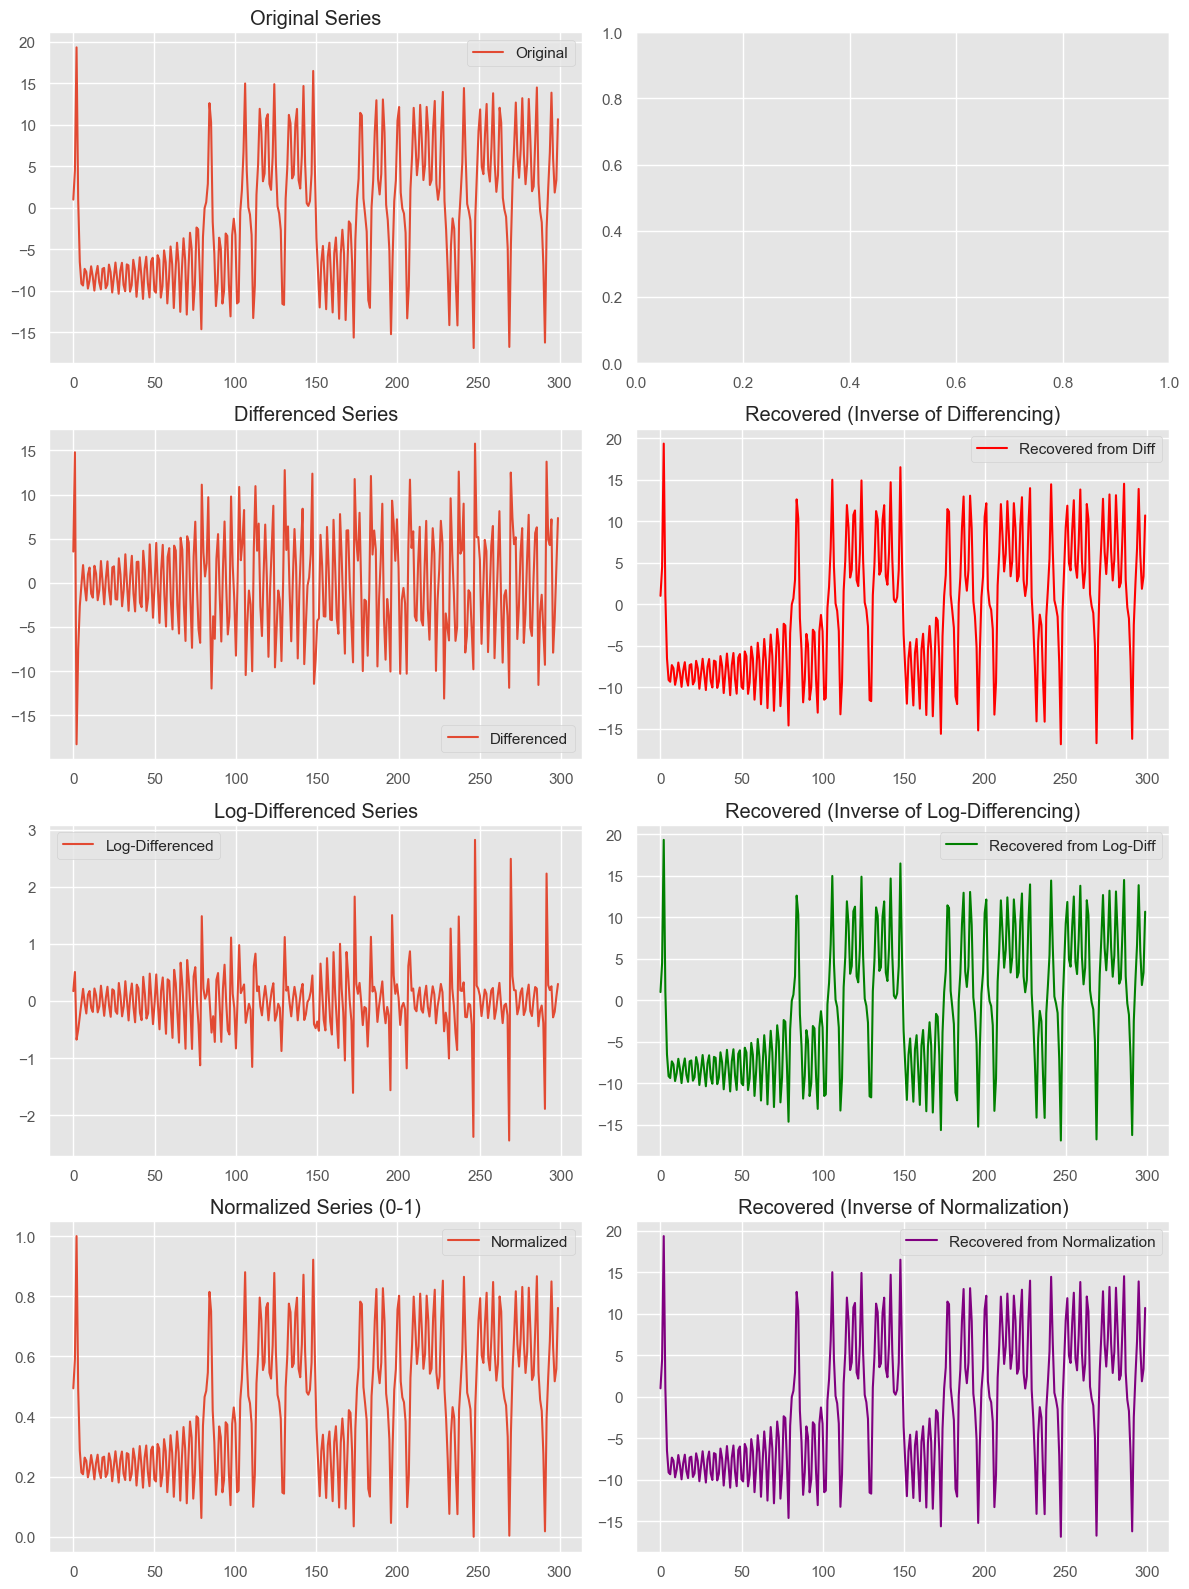

In [8]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# Original series
axs[0,0].plot(lorenz_series, label='Original')
axs[0,0].set_title("Original Series")
axs[0,0].legend()

##################
# Differencing
axs[1,0].plot(lorenz_diff, label='Differenced')
axs[1,0].set_title("Differenced Series")
axs[1,0].legend()

# Inverted differencing
axs[1,1].plot(lorenz_recovered_from_diff, label='Recovered from Diff', color='red')
axs[1,1].set_title("Recovered (Inverse of Differencing)")
axs[1,1].legend()

##################
# Log-Differencing
axs[2,0].plot(lorenz_log_diff, label='Log-Differenced')
axs[2,0].set_title("Log-Differenced Series")
axs[2,0].legend()

# Inverted log-differencing
axs[2,1].plot(lorenz_log_recovered_final, label='Recovered from Log-Diff', color='green')
axs[2,1].set_title("Recovered (Inverse of Log-Differencing)")
axs[2,1].legend()

##################
# Normalization
axs[3,0].plot(lorenz_norm, label='Normalized')
axs[3,0].set_title("Normalized Series (0-1)")
axs[3,0].legend()

# Inverted normalization
axs[3,1].plot(lorenz_norm_inv, label='Recovered from Normalization', color='purple')
axs[3,1].set_title("Recovered (Inverse of Normalization)")
axs[3,1].legend()

plt.tight_layout()
plt.show()


**Discussion of Pros and Cons:**

- **Differencing:**
  You may use differencing to remove trends, making the series stationary. But you lose absolute level information. You must remember the initial value or cumulative sum to invert it.

- **Log-Differencing:**
  You apply a log first (requires positive data), then difference. This can stabilize variance. But if your data can be zero or negative, you need a shift, which complicates interpretation.

- **Normalization (Min-Max):**
  You rescale data between 0 and 1. This is useful for machine learning models that need data in a certain range. However, if new data goes beyond this range, it can cause issues. Also, you must store min and max to invert.

- **Standardization (Z-score):**
  You transform data to have mean 0 and standard deviation 1. This helps many algorithms that assume normally distributed inputs. But outliers can heavily influence mean and std. You must remember mean and std to invert.

You need to carefully select transformations based on your modeling approach and the nature of your data.

---

## SECTION 4: Seasonal Decomposition and Basic EDA

Now you will explore a time series with seasonal components. You will generate synthetic seasonal data and then:
- Perform seasonal decomposition to see trend, seasonal, and residual components.
- Conduct basic EDA like plotting rolling means, and checking autocorrelations.

You may find that understanding seasonality and trend is crucial before forecasting.


In [9]:
np.random.seed(42)
n_points = 200
time = np.arange(n_points)

# Create a seasonal pattern: sinusoidal with a period of 12
seasonality = 10 * np.sin(2*np.pi*time/12)
trend = 0.05 * time
noise = np.random.normal(scale=2, size=n_points)

seasonal_series = trend + seasonality + noise

# Use 'MS' for month-start frequency to avoid the warning
seasonal_series = pd.Series(seasonal_series, index=pd.date_range('2000-01-01', periods=n_points, freq='MS'))

### Seasonal Decomposition

You will use `statsmodels` to decompose the time series into trend, seasonal, and residual components.


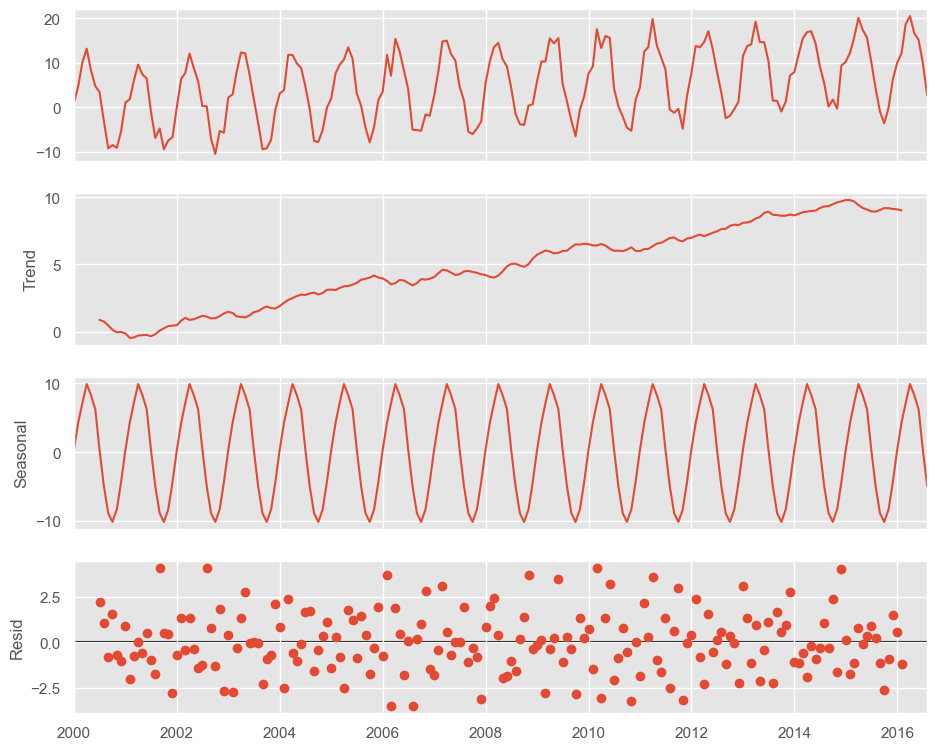

In [10]:
decomposition = sm.tsa.seasonal_decompose(seasonal_series, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()


**Analysis of Decomposition:**
- You may see a clear seasonal pattern captured in the seasonal component.
- A gradual upward slope in the trend component.
- Residuals (what's left after removing trend and seasonality) should look more random.

### Basic EDA

1. **Rolling Statistics:**
   You want to see how the mean and standard deviation evolve over time to understand if the series is stationary or not.

2. **Autocorrelation:**
   You want to look at autocorrelation plots (ACF) to understand how past values relate to future values.

You need these insights before deciding on a forecasting approach.


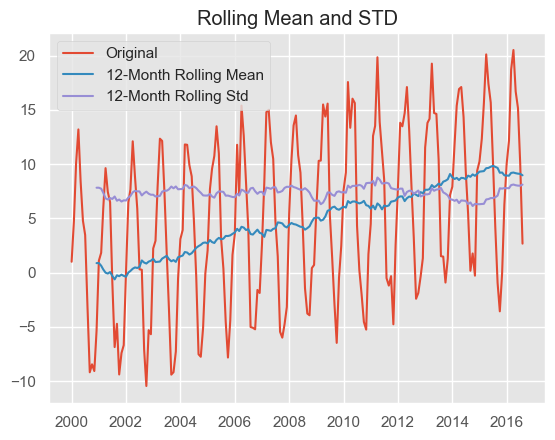

In [11]:
# Rolling mean and std
roll_mean = seasonal_series.rolling(window=12).mean()
roll_std = seasonal_series.rolling(window=12).std()

plt.figure()
plt.plot(seasonal_series, label='Original')
plt.plot(roll_mean, label='12-Month Rolling Mean')
plt.plot(roll_std, label='12-Month Rolling Std')
plt.title("Rolling Mean and STD")
plt.legend()
plt.show()


From this visualization:
- You may notice the rolling mean gradually increases (trend).
- The rolling std might change over time, indicating non-stationarity.

### Autocorrelation

Checking autocorrelation functions (ACF) can tell you how strongly the series correlates with its own past values.


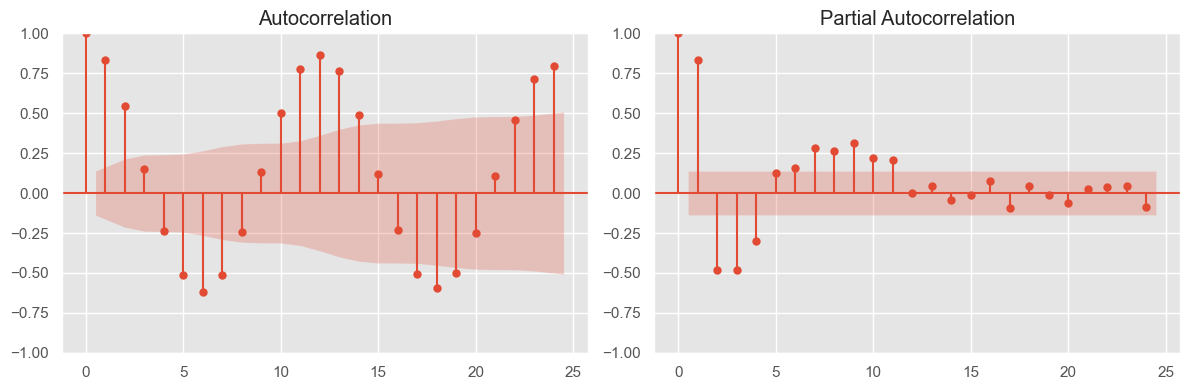

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sm.graphics.tsa.plot_acf(seasonal_series, ax=axes[0])
sm.graphics.tsa.plot_pacf(seasonal_series, ax=axes[1])
plt.tight_layout()
plt.show()


### Autocorrelation vs. Partial Autocorrelation

**Autocorrelation Function (ACF):**
The ACF measures the correlation of the time series with its own past values at different lags. For example, the ACF at lag 1 compares the series with itself shifted by one time period. High autocorrelation at a certain lag means the series is influenced by its past values at that lag. The ACF is a good initial tool to identify seasonality, because if there’s a strong seasonal pattern (e.g., a monthly cycle), you’ll often see peaks in the ACF at multiples of that seasonal period.

- **Pros of ACF:**
  - Easy to interpret as a measure of similarity between the series and its past.
  - Helps reveal seasonal patterns and overall persistence in the data.

- **Cons of ACF:**
  - It includes both direct and indirect effects of past values. For instance, the correlation at lag 2 in the ACF includes any relationship that lag 2 has via lag 1. In other words, it doesn’t isolate the "new" information each lag brings if previous lags are already accounted for.

**Partial Autocorrelation Function (PACF):**
The PACF tries to remove the influence of intermediate lags. The PACF at lag k measures the correlation between the series and its lag k after controlling for the effects of all lags before k. This gives you the "partial" correlation that’s not explained by any shorter lag relationships.

- **Pros of PACF:**
  - Helps identify the order of an autoregressive (AR) process more clearly because it shows the correlation of the series with a certain lag that is not explained by lower-order lags.
  - More directly indicates how much additional information a particular lag adds over and above the information contained in earlier lags.

- **Cons of PACF:**
  - Can be more complex to interpret at first glance, because the concept of "partial" correlation is more abstract.
  - While it clarifies the influence of each lag, it doesn’t inherently reveal seasonal patterns as simply as the ACF might.

**Summary:**
- Use **ACF** to identify patterns like seasonality and the general "memory" of the series.
- Use **PACF** to determine which lags have a direct (not indirect) impact on the current value and to help you choose the order of AR models.

By examining both ACF and PACF, you gain a fuller picture of the underlying time-dependent structure. The ACF will show all correlation patterns, while the PACF will help peel away the layers of indirect correlations, pinpointing which lags have the strongest independent influence.



**Discussion:**
- If you see significant autocorrelations at certain lags (e.g., lag=12), that might indicate seasonality or periodic patterns.
- Understanding these patterns helps you choose appropriate forecasting models (ARIMA, SARIMA, etc.).

You need to carefully analyze trend, seasonality, and autocorrelation to select the right tools for forecasting. Without this knowledge, you may pick the wrong model or fail to capture important patterns.

---

# Summary & Next Steps

- In **Section 1**, you explored different types of time series, learning that they can originate from stochastic, chaotic, or deterministic systems.
- In **Section 2**, you handled missing data using different strategies, understanding their implications.
- In **Section 3**, you learned how to preprocess and scale time series, including how to reverse these transformations.
- In **Section 4**, you performed seasonal decomposition and basic EDA, emphasizing the importance of understanding seasonality, trend, and autocorrelation before forecasting.

**Next Steps:**
- In future lectures, you may explore stationarity tests, advanced forecasting models, and methods for model evaluation and selection.
- Always remember: Before modeling, you must understand your data, handle missing values, and appropriately transform your series.

You have now a good introductory foundation to time series handling and initial analysis techniques.
